## Testing out iminuit fitting for FOM, will replace curve fit

In [1]:
# import stuff
import sys,os,os.path

sys.path.append("../../")   # cite IC from parent directory
sys.path.append("/home/e78368jw/Documents/NEXT_CODE/next_misc/")
#sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

from    IC.invisible_cities.core.core_functions   import shift_to_bin_centers

import core.functions as func
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import probfit

import scipy.special as special
from scipy.stats import norm
from scipy.stats import skewnorm
from scipy.optimize import curve_fit

from scipy.integrate import quad

import iminuit
from iminuit import Minuit

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### load and prepare data

In [2]:
folder_paths = ['75_9e-3/PORT_1a/isaura/', '75_9e-3/PORT_1b/isaura/', '75_9e-3/PORT_2a/isaura/', '75_9e-3/PORT_2b/isaura/']
full_tracks = func.collate_ports(folder_paths)

# apply cuts, SATELLITE TRACKS ARE DIFFERENT RN
#low_e_tracks = func.remove_low_E_events(full_tracks)
low_e_tracks = full_tracks[full_tracks.energy > 0.05]
# count the number of events identified with unique event, and change numb_of_tracks to reflect this
event_counts = low_e_tracks['event'].value_counts(sort = False)

# apply this to numb_of_tracks
low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)

cut_tracks = func.apply_cuts(low_e_tracks, lower_z = 20, upper_z = 1170, r_lim = 415)



Porting 75_9e-3/PORT_1a/isaura/
50
100
150
200
250
300
Done! Tracks available: 87009
Porting 75_9e-3/PORT_1b/isaura/
50
100
150
200
250
300
Tracks: 84703
Done! Tracks available: 152826
Porting 75_9e-3/PORT_2a/isaura/
50
100
150
200
250
300
Tracks: 60529
Done! Tracks available: 198973
Porting 75_9e-3/PORT_2b/isaura/
50
100
150
200
250
300
Tracks: 80864
Done! Tracks available: 259847


/tmp/ipykernel_8618/2704749952.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  low_e_tracks['numb_of_tracks'] = low_e_tracks['event'].map(event_counts)


Cutting events around fiducial volume related to:
Z range between 20 and 1170
Radius range < 415
Fiducial track cut
Relative Cut efficiency:
Efficiency: 39.84 %
Absolute Cut efficiency:
Efficiency: 39.84 %
One track cut
Relative Cut efficiency:
Efficiency: 64.26 %
Absolute Cut efficiency:
Efficiency: 52.09 %
Blob overlap cut
Relative Cut efficiency:
Efficiency: 72.74 %
Absolute Cut efficiency:
Efficiency: 72.42 %
Energy cut
Relative Cut efficiency:
Efficiency: 10.60 %
Absolute Cut efficiency:
Efficiency: 7.88 %


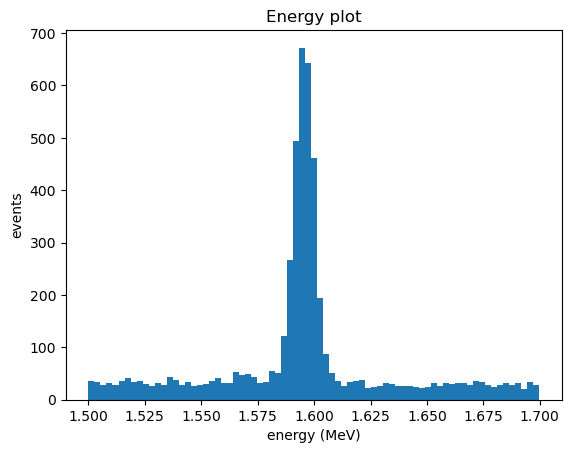

In [4]:
func.plot_hist(cut_tracks[0], binning = 75, log = False)

In [5]:
# find positron events per port
pos_events = func.positron_ports(folder_paths)

Loading positrons from 75_9e-3/PORT_1a/isaura/
Port finished! Tracks available: 13282
Loading positrons from 75_9e-3/PORT_1b/isaura/
Positron events: 12865
Port finished! Tracks available: 25717
Loading positrons from 75_9e-3/PORT_2a/isaura/
Positron events: 9663
Port finished! Tracks available: 34976
Loading positrons from 75_9e-3/PORT_2b/isaura/
Positron events: 12817
Port finished! Tracks available: 47202


In [6]:
# collect positron events and non-positron events
ecut_positron_df = cut_tracks[0][cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]
ecut_no_positron_df = cut_tracks[0][~cut_tracks[0]['event'].isin(pos_events['event_id'].to_numpy())]

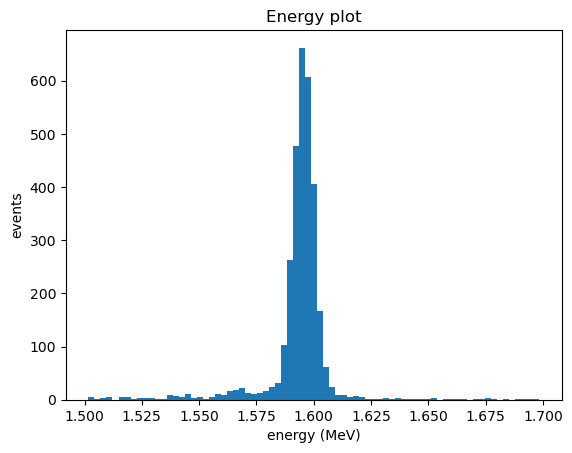

In [7]:
func.plot_hist(ecut_positron_df, binning = 75, log = False)

In [8]:
cut_list = np.linspace(0,0.6, 61)

# Fit
#fom_out_fit = func.fom_calc_MC(cut_tracks[0], pos_events, cut_list, binning = 60)

In [9]:
def fit(c, C1, C2, mu, sigma):
    m = Minuit(c, ns = 400, a = 1, nb = 20, tau = 0.1, C1 = C1, C2 = C2, mu = mu, sigma = sigma)
    m.fixed['mu'] = True
    m.fixed['sigma'] = True
    m.fixed['C1'] = True
    m.fixed['C2'] = True
    m.limits["ns", "nb"] = (0, None)
    m.migrad()
    assert m.valid
    return m

In [10]:
# create a distribution function for the bins
def integral(xe, ns, a, mu, sigma, C1, C2, nb, tau):

    return ns * skewnorm_func.cdf(x, a, mu, sigma) + C1 

### unbinned extended maximum likelihood fit for C1 C2 

In [9]:
# set range we're considering
fit_range = (1.5, 1.7)
binning = 80

In [10]:
def bck_func_no_N(x, tau):
    return np.exp(-x/tau)

def gauss_no_N(x, mu, sigma):
    numer = np.square(x - mu)
    denom = 2*np.square(sigma)

    return np.exp(-numer/denom)

In [11]:
# Normalise and extend
sig_norm = probfit.Normalized(func.sig_func_no_N, fit_range)
sig_norm_ext = probfit.Extended(sig_norm, extname = 'Ns')

bck_norm = probfit.Normalized(bck_func_no_N, fit_range)
bck_norm_ext = probfit.Extended(bck_norm, extname = 'Nb')

gauss_norm = probfit.Normalized(gauss_no_N, fit_range)
gauss_norm_ext_ = probfit.Extended(gauss_norm, extname = 'Ng')

In [21]:

e_s = ecut_positron_df['energy'].to_numpy()
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)



In [22]:
# minimise that mfer
m.migrad()

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   0 - FCN =  -29689.44352174 Edm =      1562.15 NCalls =     72
VariableMetric: Iteration #   1 - FCN =  -31245.53859823 Edm =      4101.86 NCalls =     93
VariableMetric: Iteration #   2 - FCN =  -32701.34672537 Edm =      154.269 NCalls =    115
VariableMetric: Iteration #   3 - FCN =  -32748.75879748 Edm =      97.5243 NCalls =    129
VariableMetric: Iteration #   4 - FCN =  -32785.39340618 Edm =      6.77937 NCalls =    143
VariableMetric: Iteration #   5 - FCN =  -32789.28646603 Edm =      8.52043 NCalls =    157
VariableMetric: Iteration #   6 - FCN =  -32793.78683505 Edm =      1.10539 NCalls =    171
VariableMetric: Iteration #   7 - FCN =  -32801.06577986 Edm =       2.8386 NCalls =    187
VariableMetric: Iteration #   8 - FCN =  -32810.06312682 Edm =       3.7456 NCalls =    205
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -3.282e+04                 │        Nfcn = 410 (410 total)        │
│ EDM = 2.28e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

 22 - FCN =  -32817.88581241 Edm =  2.28003e-05 NCalls =    410


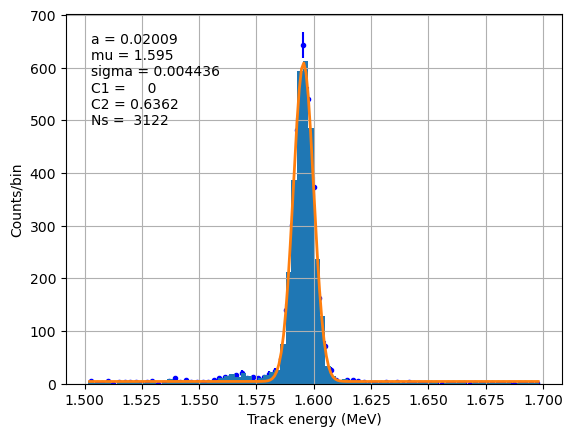

"\nC1_test = 1\nx_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE\ny_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)\nplt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))\nplt.ylim([0,600])\nplt.legend()\nplt.show()\n"

In [23]:
# plot output
heights, bins, _ = plt.hist(e_s, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)


'''
C1_test = 1
x_points = np.linspace(1.5, 1.7, 20000)                 # C1 PARAMETER HERE
y_points = func.sig_func(x_points, 6, 0.02, 1.5955, 0.004436, C1_test, 0.6362)
plt.plot(x_points, y_points, label = 'C1 = {}'.format(C1_test))
plt.ylim([0,600])
plt.legend()
plt.show()
'''

In [24]:
# collect C1 and C2
print(m.params)
C2 = m.params[4][2]
C1 = m.params[3][2]
# collect the gaussian here as well
mu = m.params[1][2]
sigma = m.params[2][2]

┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │    0.0    │    0.8    │            │            │         │         │       │
│ 1 │ mu    │  1.5955   │  0.0028   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.44e-3  │  0.13e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.000   │   0.004   │            │            │    0    │         │       │
│ 4 │ C2    │   0.64    │   0.04    │            │            │    0    │         │       │
│ 5 │ Ns    │  3.13e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘


In [26]:
'''
# do signal and background fit over all the data now
e_tracks = cut_tracks[0]['energy'].to_numpy()

# create signal background pdf
pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

lh_sb = probfit.UnbinnedLH(pdf_sb, e_tracks, extended = True)


y, x = np.histogram(e_tracks, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals_sb = [len(e_s), len(e_tracks) - len(e_s), 0, mu, sigma, 100, C1, C2]
nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']



m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

/tmp/ipykernel_12999/4010954509.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)


In [27]:
'''
# minimise that mfer
m_sb.migrad()
'''

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -50898.70076061 Edm =     0.919755 NCalls =     60
VariableMetric: Iteration #   0 - FCN =  -50898.70076061 Edm =     0.919755 NCalls =     60
VariableMetric: Iteration #   1 - FCN =  -50899.81884284 Edm =    0.0440465 NCalls =     73
VariableMetric: Iteration #   2 - FCN =  -50899.88942423 Edm =   0.00690139 NCalls =     83
VariableMetric: Iteration #   3 - FCN =  -50899.90380749 Edm =   0.00079092 NCalls =     94
VariableMetric: Iteration #   4 - FCN =  -50899.90453307 Edm =  1.86099e-05 NCalls =    104
┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.09e+04                  │        Nfcn = 133 (133 total)        │
│ EDM = 6.91e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├─────────────

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -5.09e+04                  │        Nfcn = 133 (133 total)        │
│ EDM = 6.91e-06 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.021   │   0.028   │            │            │         │         │       │
│ 1 │ mu    │   1.595   │   0.016   │            │            │         │         │  yes  │
│ 2 │ sigma │  4.44e-3  │  0.04e-3  │            │            │         │         │  yes  │
│ 3 │ C1    │    0.0    │    0.1    │            │            │         │         │  yes  │
│ 4 │ C2    │   0.636   │   0.006   │            │            │         │         │  yes  │
│ 5 │ Ns    │  3.09e3   │  0.06e3   │            │            │         │         │       │
│ 6 │ tau   │   0.74    │   0.23    │            │            │         │         │       │
│ 7 │ Nb    │  2.04e3   │  0.05e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

VariableMetric: After Hessian   - FCN =  -50899.90453307 Edm =  6.91212e-06 NCalls =    133
VariableMetric: Iteration #   5 - FCN =  -50899.90453307 Edm =  6.91212e-06 NCalls =    133


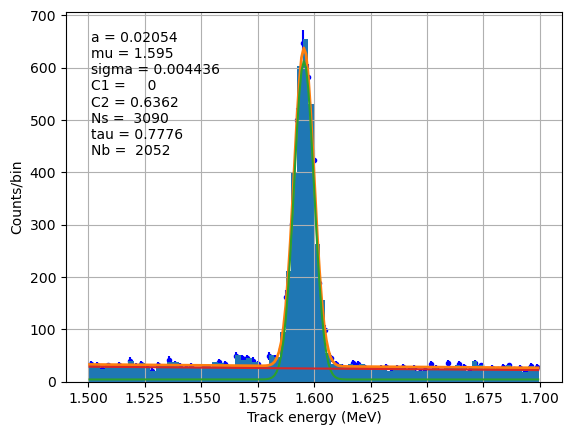

In [29]:
'''
# plot output
heights, bins, _ = plt.hist(e_tracks, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_sb.show(bins=binning+1, parts=True)
plt.show()
'''

In [74]:
'''
display(m_sb.params)
print(m_sb.params[0][1], m_sb.params[0][2])
print(len(m.params)+1)
'''

,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed
0,a,0.021,0.028,,,,,
1,mu,1.595,0.016,,,,,yes
2,sigma,4.44e-3,0.04e-3,,,,,yes
3,C1,0.0,0.1,,,,,yes
4,C2,0.636,0.006,,,,,yes
5,Ns,3.09e3,0.06e3,,,,,
6,tau,0.74,0.23,,,,,
7,Nb,2.04e3,0.05e3,,,,,


a 0.02053640229638344
7


In [12]:
def add_element(dict, key, value):
    if key not in dict:
        dict[key] = value
    #dict[key].append(value)

# pull out the relevant values
#fit_params = {}
#[add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

In [56]:
# collect the fom stuff
#ns0 = quad(func.sig_func, fit_range[0], fit_range[1], args = (fit_params['Ns'],fit_params['a'], mu, sigma, C1, C2))#/bin_width
#nb0 = quad(func.bck_func, fit_range[0], fit_range[1], args = (fit_params['Nb'], fit_params['tau']))#/bin_width

#####print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(cut_tracks[0].index)))

Signal events: 3089.642561895908
Background events: 2043.4841044096916
Total Events by addition: 5133.126666305599
Total Events by row counting: 5131


In [101]:
'''
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []

ns0 = fit_params['Ns']
nb0 = fit_params['Nb']
ns_l.append(fit_params['Ns'])
nb_l.append(fit_params['Nb'])
'''

In [102]:
'''
print(ns_l)
print(nb_l)
'''

[3089.642561895908]
[2043.4841044096916]


### now to create the loop, and collect the gaussian and the full fit on repeat (this takes ages)

In [15]:
#del lh_g
#del m_g 
# create list for fom values
e       = []
b       = []
ns_l      = []
nb_l      = []
fom     = []
fom_err = []
e_err = []
b_err = []


def gaussian_fit(data, plot = False):
    '''
    Fit gaussian to the data
    '''
    blob_np = data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1))
    
    # minimise it
    m_g.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_data, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']


    return (mu, sigma)


def sb_fit(data, mu, sigma, C1, C2, plot = False):
    '''
    Fit signal and background to data
    '''
    blob_np = data['energy'].to_numpy()
    # create signal background pdf
    pdf_sb = probfit.AddPdf(sig_norm_ext, bck_norm_ext)

    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [len(blob_np)/2, len(blob_np)/2, 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, limit_tau=(0.1,None))

    # minimise that mfer
    m_sb.migrad()

    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_sb.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    return (fit_params['Ns'], fit_params['Nb'])



Blob cut: 0.0 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


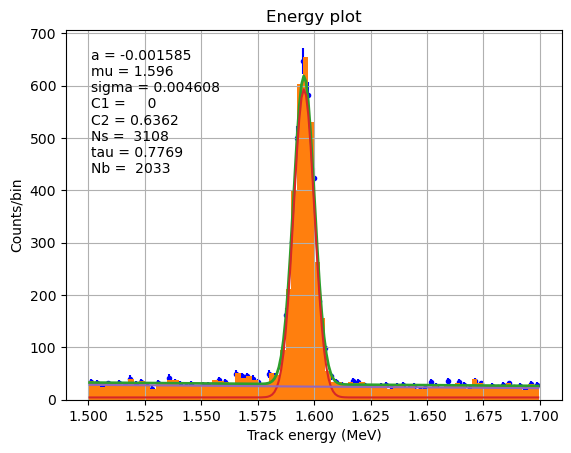

Signal events: 3107.9100306888936
Background events: 2025.062862755114
Total Events by addition: 5132.972893444008
Total Events by row counting: 5131


Blob cut: 0.01 MeV
Mu fit completed, with values:
mu: 1.595520279733812
sigma: 0.004607638815220153


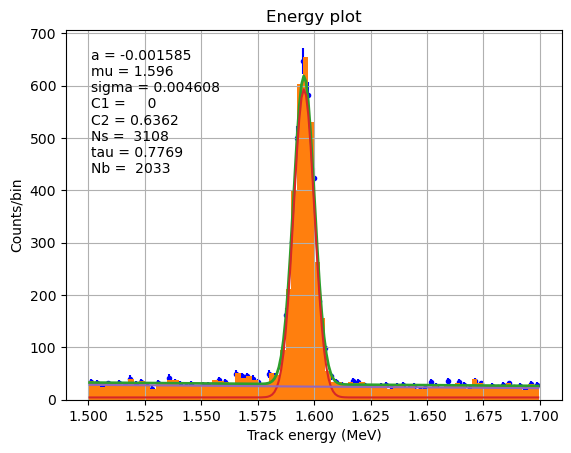

Signal events: 3107.9100306888936
Background events: 2025.062862755114
Total Events by addition: 5132.972893444008
Total Events by row counting: 5131


Blob cut: 0.02 MeV
Mu fit completed, with values:
mu: 1.595504600275164
sigma: 0.004626785828026376


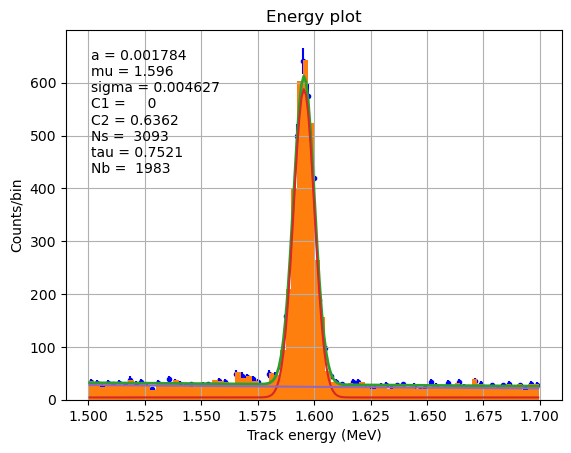

Signal events: 3093.1424692037544
Background events: 1974.7924664349498
Total Events by addition: 5067.934935638705
Total Events by row counting: 5066


Blob cut: 0.03 MeV
Mu fit completed, with values:
mu: 1.5955110044119565
sigma: 0.004626037628055603


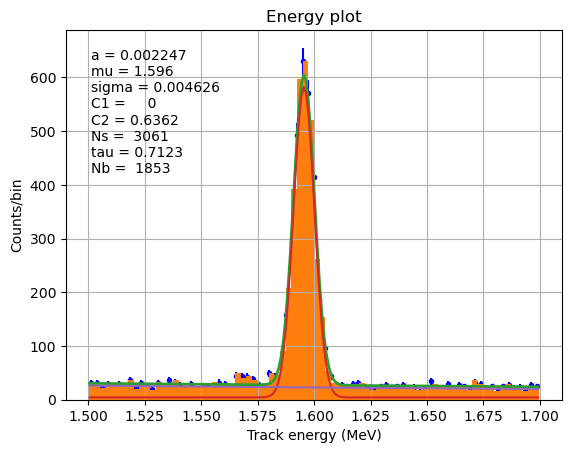

Signal events: 3060.8928432985767
Background events: 1845.1910634251446
Total Events by addition: 4906.083906723721
Total Events by row counting: 4904


Blob cut: 0.04 MeV
Mu fit completed, with values:
mu: 1.595504748798143
sigma: 0.004622441854325208


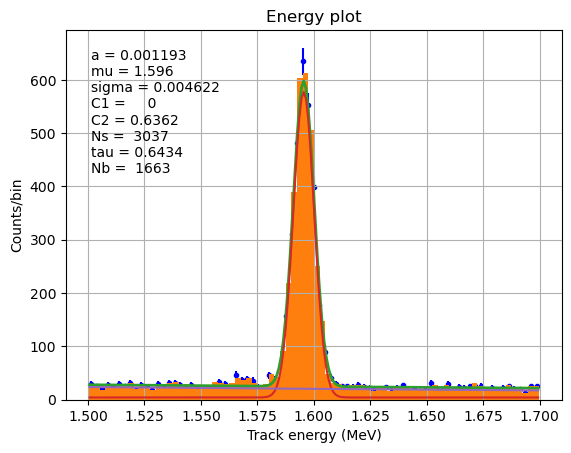

Signal events: 3037.4190198577608
Background events: 1655.724739816332
Total Events by addition: 4693.1437596740925
Total Events by row counting: 4689


Blob cut: 0.05 MeV
Mu fit completed, with values:
mu: 1.5954979365663284
sigma: 0.00459477738466024


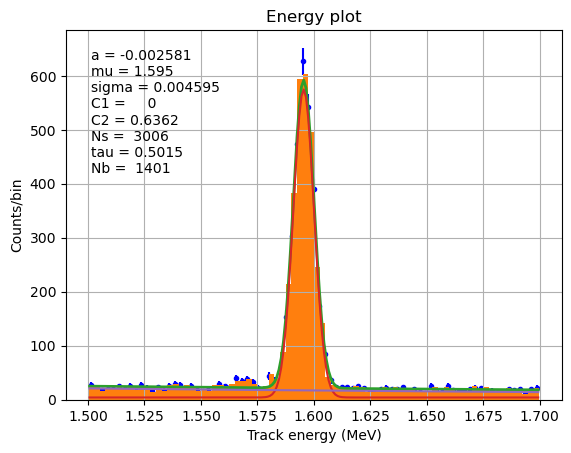

Signal events: 3005.8070620390395
Background events: 1394.7772641103868
Total Events by addition: 4400.5843261494265
Total Events by row counting: 4397


Blob cut: 0.06 MeV
Mu fit completed, with values:
mu: 1.5954877330945365
sigma: 0.004552572600168257


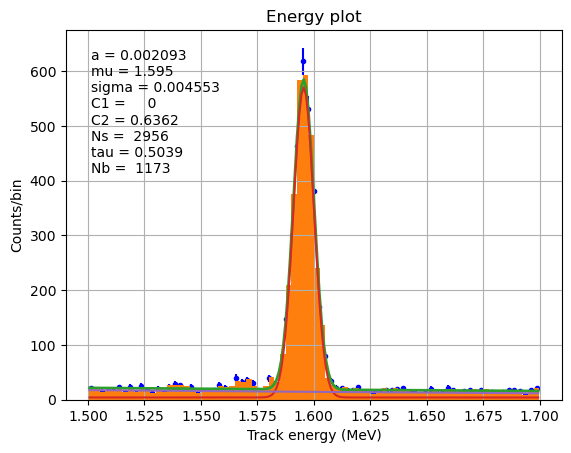

Signal events: 2956.3678836571607
Background events: 1166.8756609335835
Total Events by addition: 4123.243544590744
Total Events by row counting: 4120


Blob cut: 0.07 MeV
Mu fit completed, with values:
mu: 1.5955006047829132
sigma: 0.0045298058451089


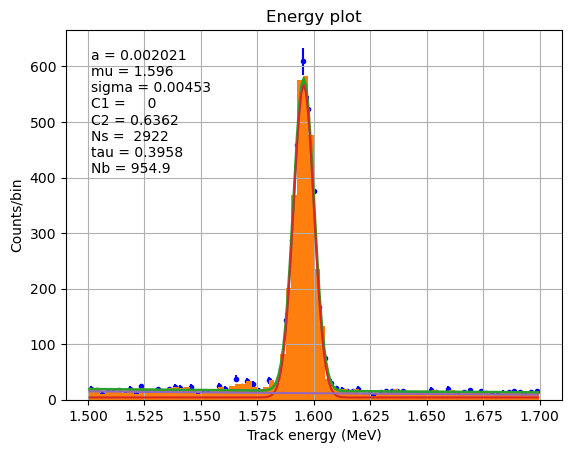

Signal events: 2921.867099176934
Background events: 949.7784861195763
Total Events by addition: 3871.6455852965105
Total Events by row counting: 3869


Blob cut: 0.08 MeV
Mu fit completed, with values:
mu: 1.5954820828521408
sigma: 0.004519758424577733


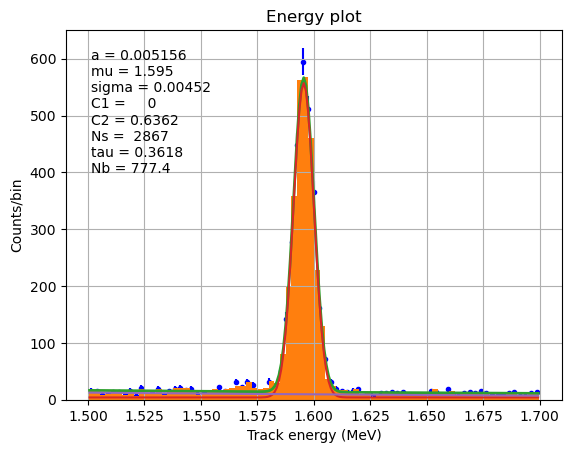

Signal events: 2866.569897257807
Background events: 772.7072525727684
Total Events by addition: 3639.2771498305756
Total Events by row counting: 3637


Blob cut: 0.09 MeV
Mu fit completed, with values:
mu: 1.5955609147859262
sigma: 0.004386502887349341


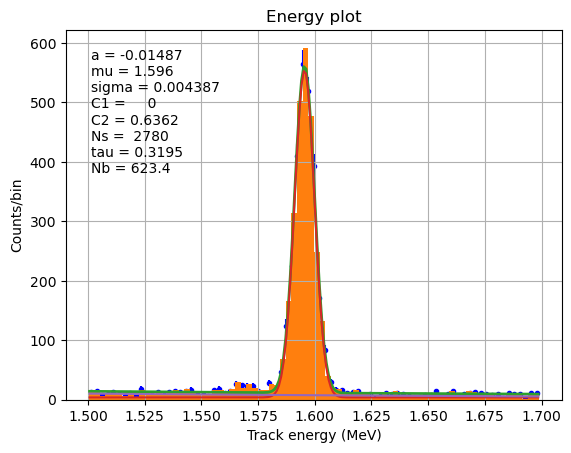

Signal events: 2779.697087923696
Background events: 619.2982129836518
Total Events by addition: 3398.995300907348
Total Events by row counting: 3394


Blob cut: 0.1 MeV
Mu fit completed, with values:
mu: 1.5955697301253424
sigma: 0.00438944386419588


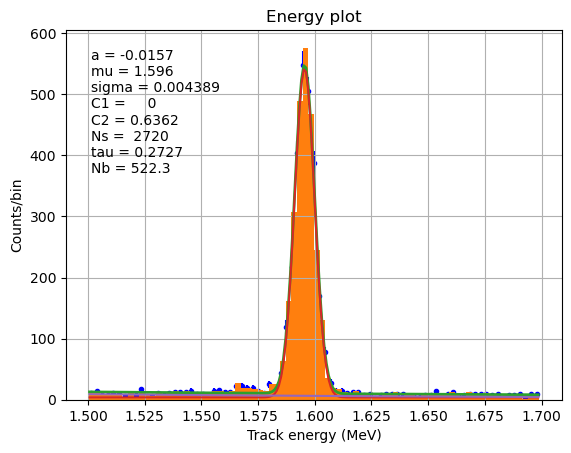

Signal events: 2720.2659326745843
Background events: 526.1667819432821
Total Events by addition: 3246.4327146178666
Total Events by row counting: 3242


Blob cut: 0.11 MeV
Mu fit completed, with values:
mu: 1.5955633079548286
sigma: 0.00436468150023408


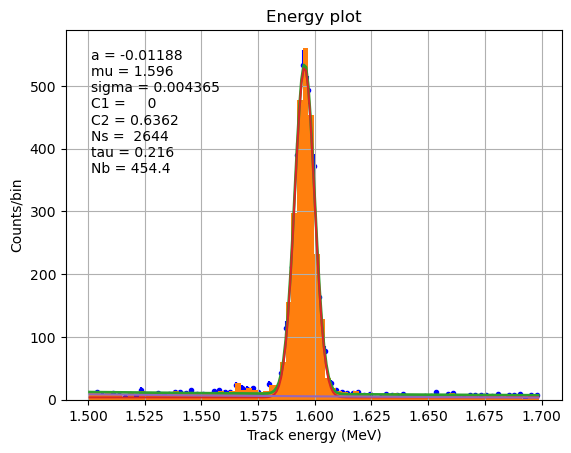

Signal events: 2644.1484062531
Background events: 450.84948112060005
Total Events by addition: 3094.9978873737
Total Events by row counting: 3091


Blob cut: 0.12 MeV
Mu fit completed, with values:
mu: 1.595557204597413
sigma: 0.004319157777568019


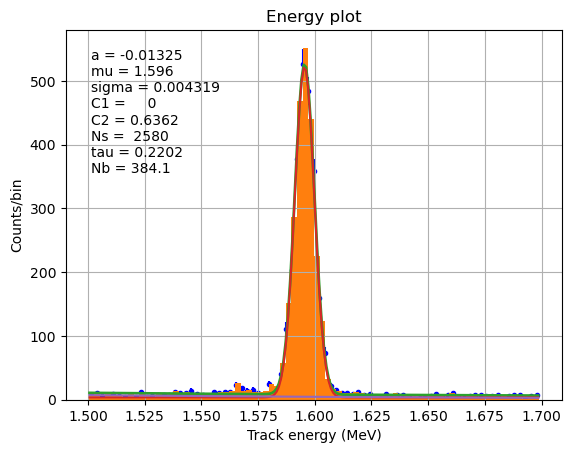

Signal events: 2579.6143801620365
Background events: 380.8641579877033
Total Events by addition: 2960.47853814974
Total Events by row counting: 2957


Blob cut: 0.13 MeV
Mu fit completed, with values:
mu: 1.5955739817912915
sigma: 0.004319300683509021


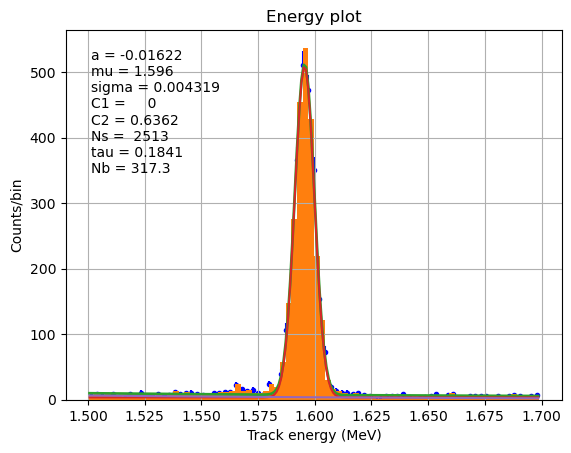

Signal events: 2512.801517585952
Background events: 314.25891599400484
Total Events by addition: 2827.0604335799567
Total Events by row counting: 2824


Blob cut: 0.14 MeV
Mu fit completed, with values:
mu: 1.5955803768898256
sigma: 0.004334038739584292


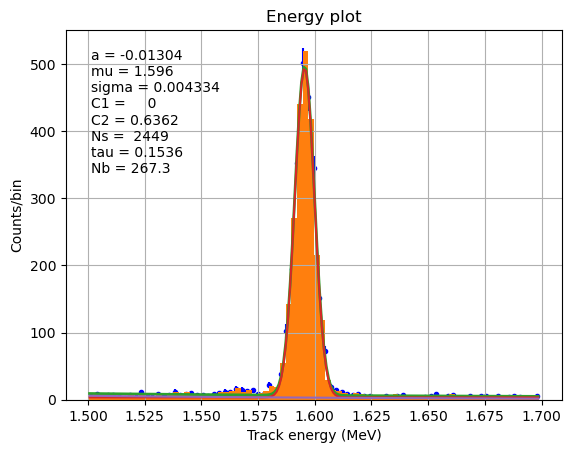

Signal events: 2449.426921212525
Background events: 264.5034366879007
Total Events by addition: 2713.930357900426
Total Events by row counting: 2711


Blob cut: 0.15 MeV
Mu fit completed, with values:
mu: 1.595580298665907
sigma: 0.004321644138403575


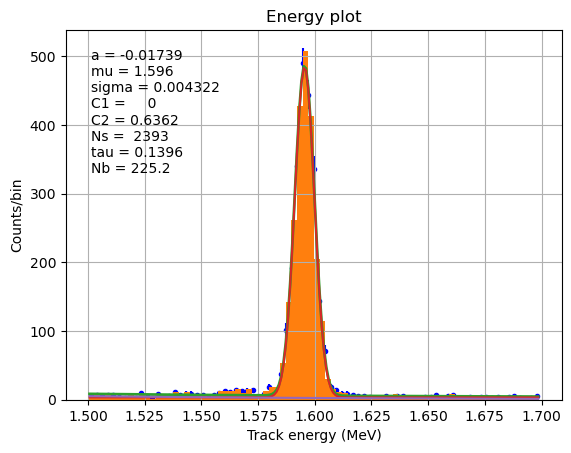

Signal events: 2392.9273873451943
Background events: 222.57692096594775
Total Events by addition: 2615.5043083111423
Total Events by row counting: 2613


Blob cut: 0.16 MeV
Mu fit completed, with values:
mu: 1.5955491545609597
sigma: 0.004330843943514996


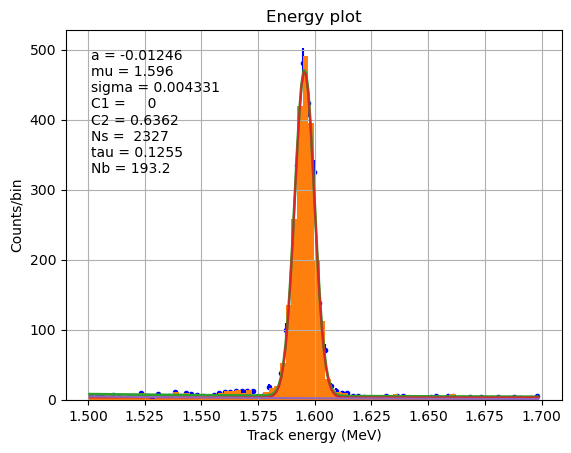

Signal events: 2326.834392336165
Background events: 190.82586576851406
Total Events by addition: 2517.660258104679
Total Events by row counting: 2515


Blob cut: 0.17 MeV
Mu fit completed, with values:
mu: 1.5955704193901794
sigma: 0.004325684463127033


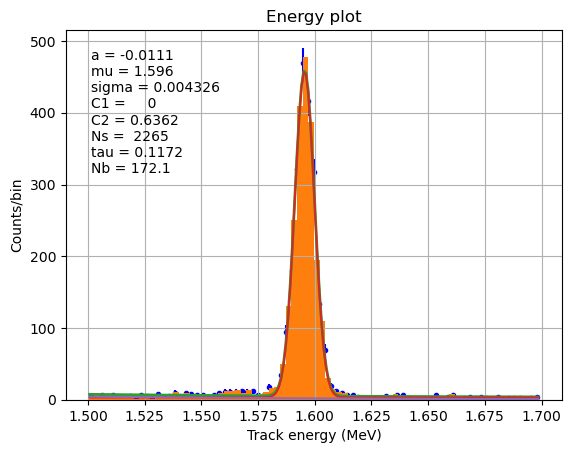

Signal events: 2265.4065587697423
Background events: 169.8349179843858
Total Events by addition: 2435.241476754128
Total Events by row counting: 2433


Blob cut: 0.18 MeV
Mu fit completed, with values:
mu: 1.5955593546776385
sigma: 0.004331953927925015


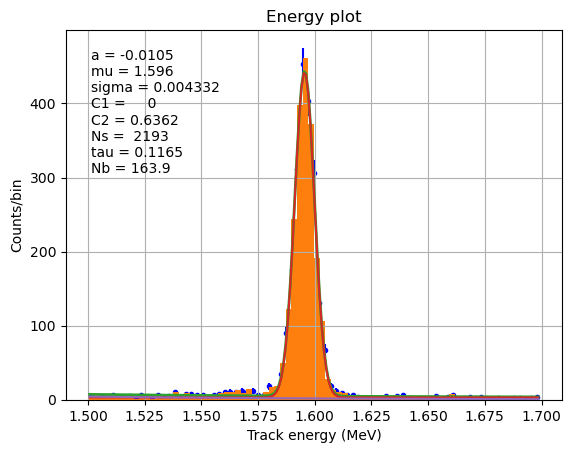

Signal events: 2193.397549837281
Background events: 161.75538097413659
Total Events by addition: 2355.1529308114177
Total Events by row counting: 2353


Blob cut: 0.19 MeV
Mu fit completed, with values:
mu: 1.595580648206708
sigma: 0.004310744077236134


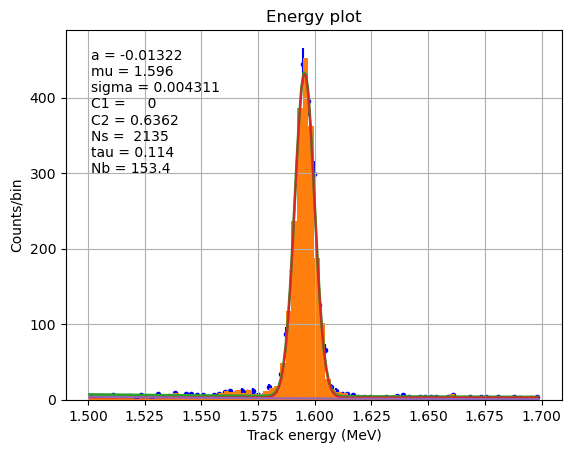

Signal events: 2134.856696955015
Background events: 151.26506548692026
Total Events by addition: 2286.1217624419355
Total Events by row counting: 2284


Blob cut: 0.2 MeV
Mu fit completed, with values:
mu: 1.5955743861887892
sigma: 0.004286852284455332


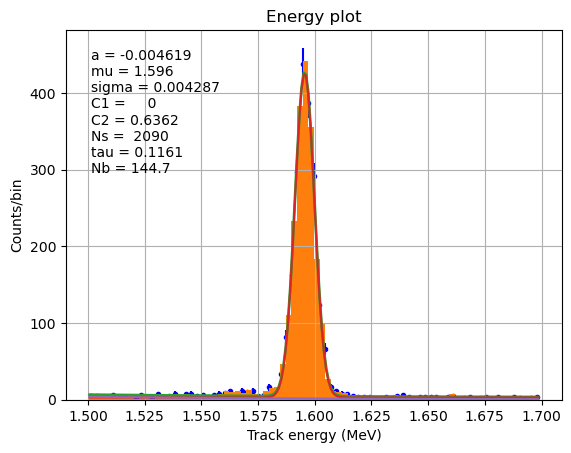

Signal events: 2090.299532191033
Background events: 142.65218161166047
Total Events by addition: 2232.9517138026936
Total Events by row counting: 2231


Blob cut: 0.21 MeV
Mu fit completed, with values:
mu: 1.5955761269151822
sigma: 0.004295215667989439


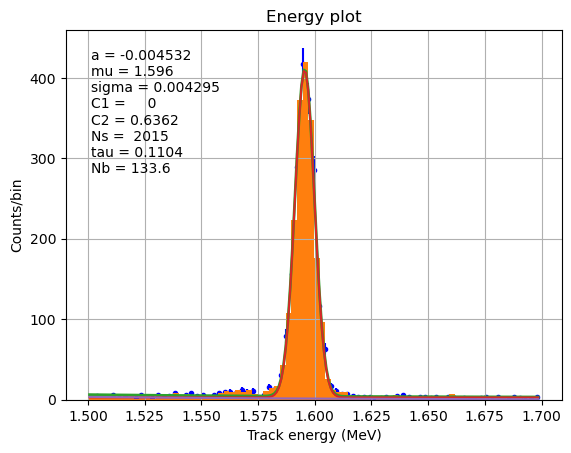

Signal events: 2014.560892321159
Background events: 131.61997629325012
Total Events by addition: 2146.180868614409
Total Events by row counting: 2144


Blob cut: 0.22 MeV
Mu fit completed, with values:
mu: 1.595566685824677
sigma: 0.0043000982441349575


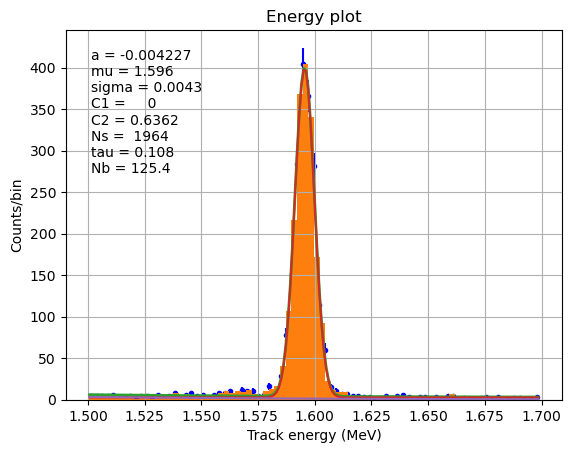

Signal events: 1964.4369141462364
Background events: 123.48642213458524
Total Events by addition: 2087.923336280822
Total Events by row counting: 2086


Blob cut: 0.23 MeV
Mu fit completed, with values:
mu: 1.5955480718648172
sigma: 0.004319222228034892


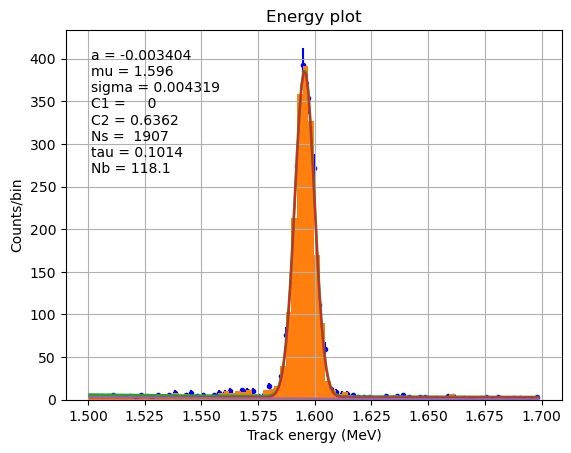

Signal events: 1906.5063474308806
Background events: 118.1422390411546
Total Events by addition: 2024.6485864720353
Total Events by row counting: 2023


Blob cut: 0.24 MeV
Mu fit completed, with values:
mu: 1.5956417419504507
sigma: 0.0044291564571970615


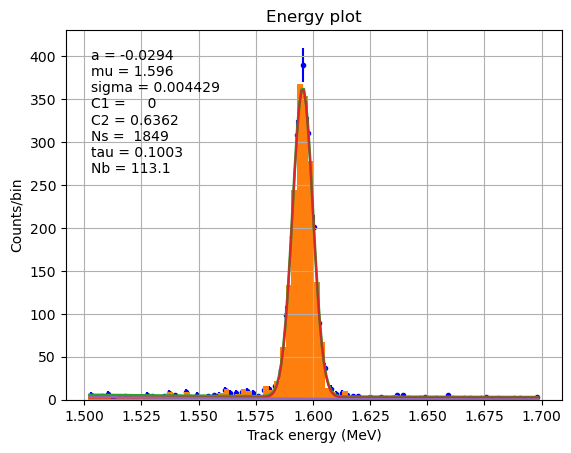

Signal events: 1848.824340973798
Background events: 111.40504965337905
Total Events by addition: 1960.229390627177
Total Events by row counting: 1955


Blob cut: 0.25 MeV
Mu fit completed, with values:
mu: 1.595626877320212
sigma: 0.0044112023575381505


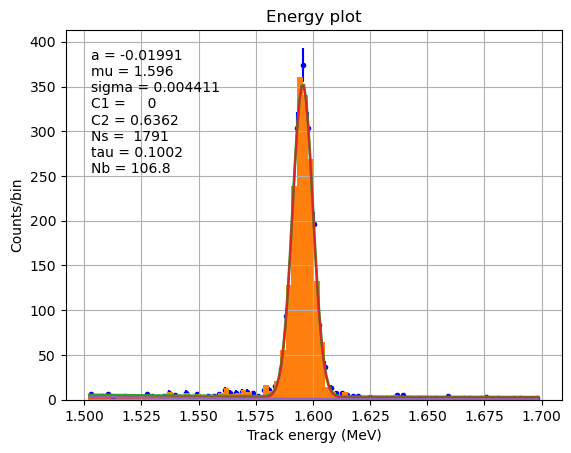

Signal events: 1791.0670967489255
Background events: 105.13108236937326
Total Events by addition: 1896.1981791182986
Total Events by row counting: 1891


Blob cut: 0.26 MeV
Mu fit completed, with values:
mu: 1.5956233271175853
sigma: 0.0044115675517954625


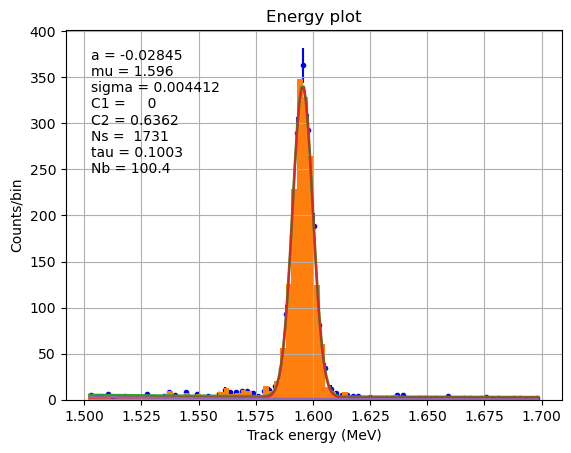

Signal events: 1731.0787493711991
Background events: 98.80578450207258
Total Events by addition: 1829.8845338732717
Total Events by row counting: 1825


Blob cut: 0.27 MeV
Mu fit completed, with values:
mu: 1.5956130998736557
sigma: 0.0044159865031185895


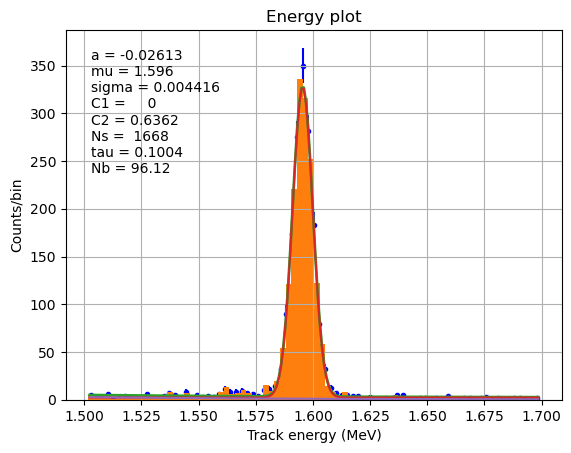

Signal events: 1668.0177350771698
Background events: 94.57451405784646
Total Events by addition: 1762.5922491350163
Total Events by row counting: 1758


Blob cut: 0.28 MeV
Mu fit completed, with values:
mu: 1.595663844718282
sigma: 0.004398588018576116


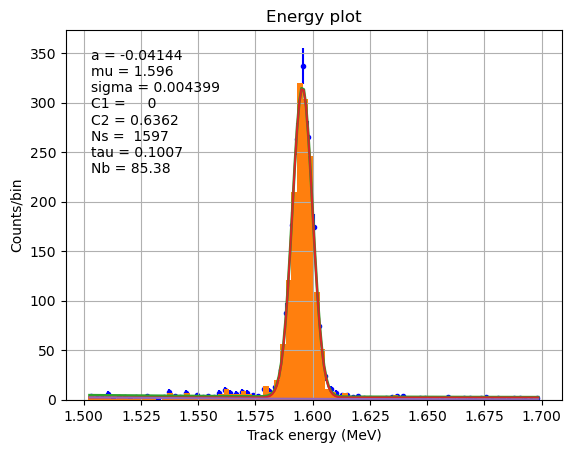

Signal events: 1596.821145610866
Background events: 83.92321783516664
Total Events by addition: 1680.7443634460328
Total Events by row counting: 1676


Blob cut: 0.29 MeV
Mu fit completed, with values:
mu: 1.5956357381213564
sigma: 0.004351028995471657


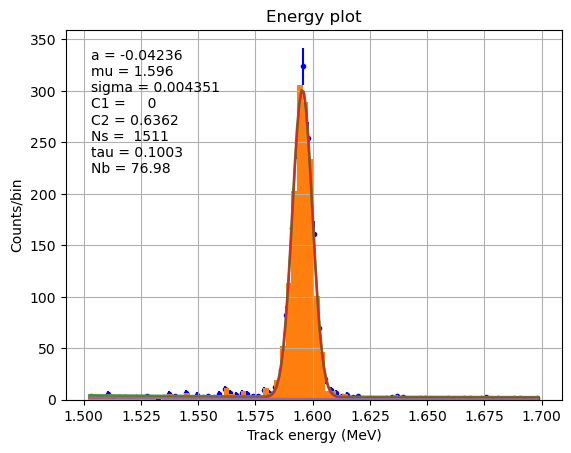

Signal events: 1510.741677699103
Background events: 75.6246182415893
Total Events by addition: 1586.3662959406925
Total Events by row counting: 1582


Blob cut: 0.3 MeV
Mu fit completed, with values:
mu: 1.5956369664334196
sigma: 0.004364832260753181


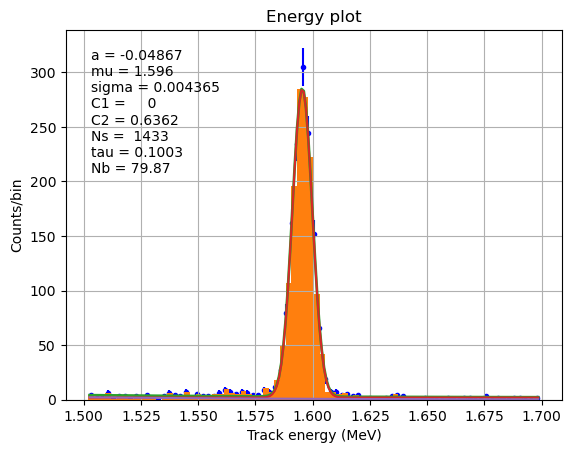

Signal events: 1432.735243360812
Background events: 78.56605246212196
Total Events by addition: 1511.301295822934
Total Events by row counting: 1507


Blob cut: 0.31 MeV
Mu fit completed, with values:
mu: 1.5956633378230591
sigma: 0.004358572469476637


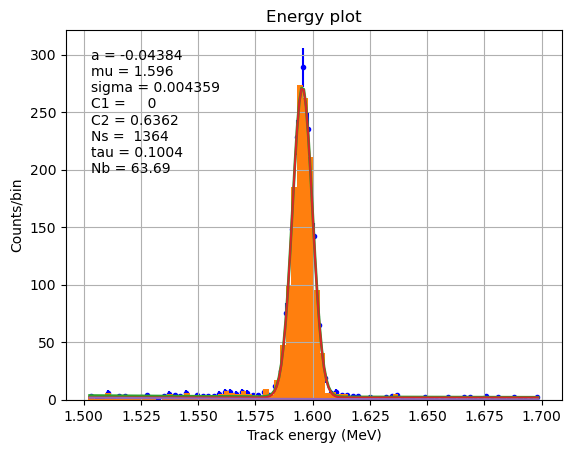

Signal events: 1364.3073046800198
Background events: 62.496623654077304
Total Events by addition: 1426.803928334097
Total Events by row counting: 1423


Blob cut: 0.32 MeV
Mu fit completed, with values:
mu: 1.5956241480591882
sigma: 0.004346690085039995


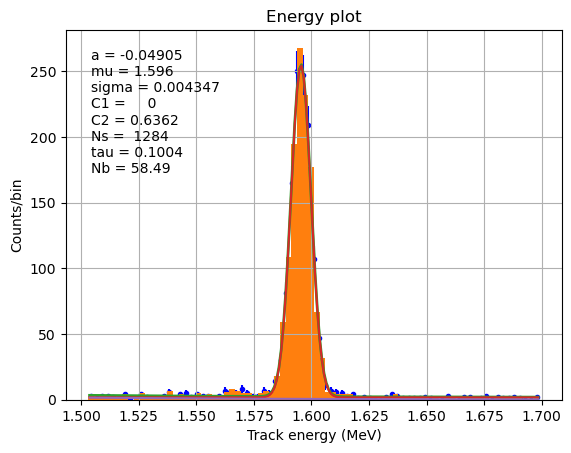

Signal events: 1283.59918199416
Background events: 57.366534922461575
Total Events by addition: 1340.9657169166217
Total Events by row counting: 1336


Blob cut: 0.33 MeV
Mu fit completed, with values:
mu: 1.5956590872803602
sigma: 0.004282356869393286


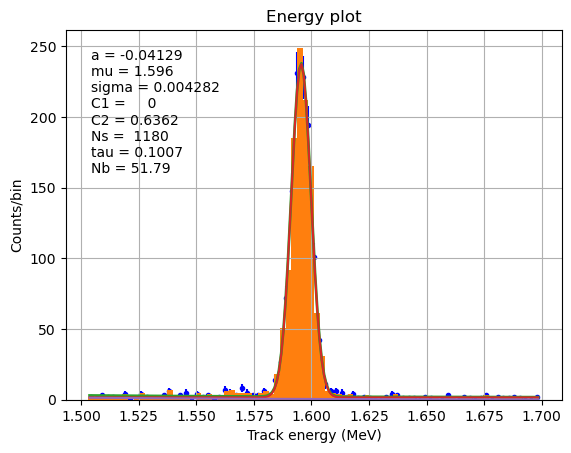

Signal events: 1179.7842595943018
Background events: 50.7627303995501
Total Events by addition: 1230.5469899938519
Total Events by row counting: 1226


Blob cut: 0.34 MeV
Mu fit completed, with values:
mu: 1.5956158596611878
sigma: 0.0042166000528445135


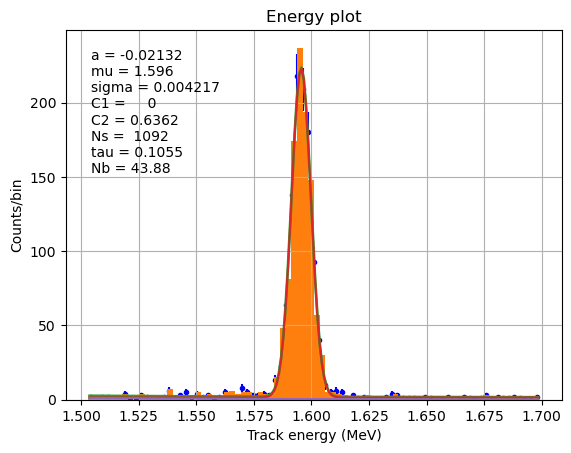

Signal events: 1092.037732779684
Background events: 42.95042926543683
Total Events by addition: 1134.9881620451208
Total Events by row counting: 1131


Blob cut: 0.35000000000000003 MeV
Mu fit completed, with values:
mu: 1.595562317659029
sigma: 0.004205163837276018


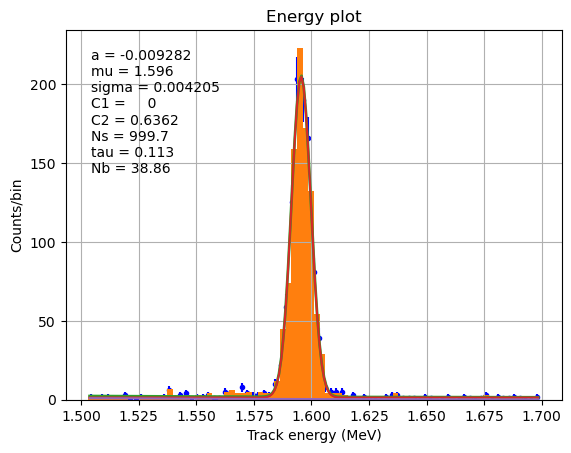

Signal events: 999.6802179218163
Background events: 38.004748124055624
Total Events by addition: 1037.684966045872
Total Events by row counting: 1034


Blob cut: 0.36 MeV
Mu fit completed, with values:
mu: 1.5955980265218144
sigma: 0.004156013915162451


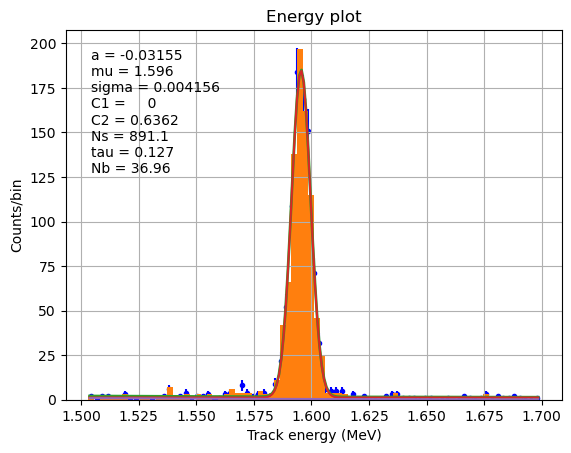

Signal events: 891.1098717872102
Background events: 36.18996012543703
Total Events by addition: 927.2998319126472
Total Events by row counting: 924


Blob cut: 0.37 MeV
Mu fit completed, with values:
mu: 1.5955158819909692
sigma: 0.00418909213638729


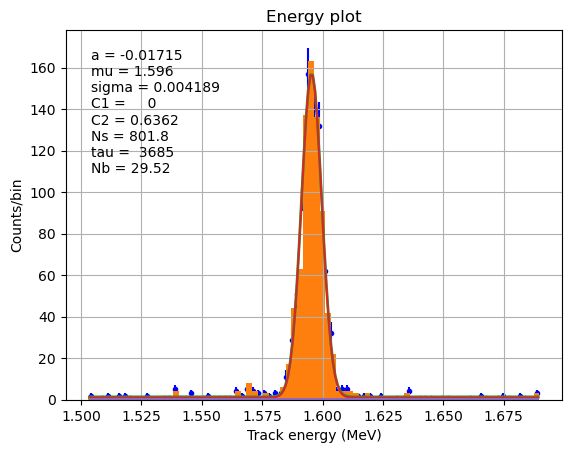

Signal events: 801.7932398258185
Background events: 30.260836606274708
Total Events by addition: 832.0540764320932
Total Events by row counting: 824


Blob cut: 0.38 MeV
Mu fit completed, with values:
mu: 1.5955476942953606
sigma: 0.004143393772054352


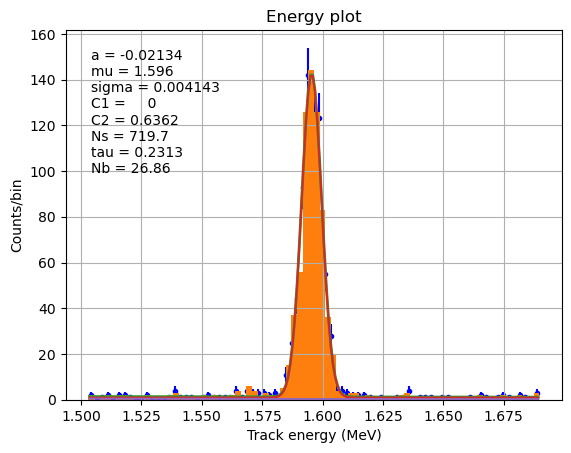

Signal events: 719.690643664645
Background events: 26.22693234555725
Total Events by addition: 745.9175760102022
Total Events by row counting: 739


Blob cut: 0.39 MeV
Mu fit completed, with values:
mu: 1.5956574358559243
sigma: 0.004138790219961694


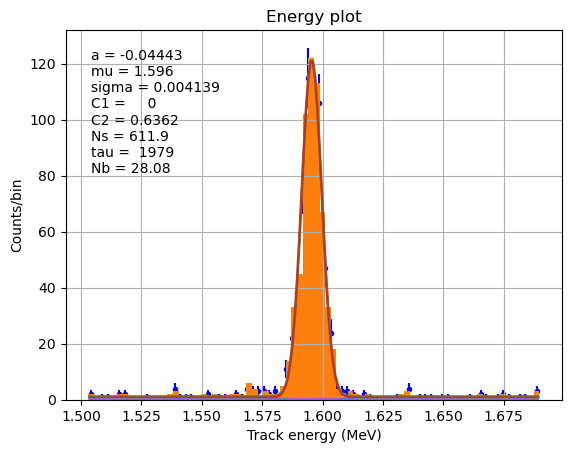

Signal events: 611.8970510918338
Background events: 28.656501652959495
Total Events by addition: 640.5535527447933
Total Events by row counting: 634


Blob cut: 0.4 MeV
Mu fit completed, with values:
mu: 1.5957535695403604
sigma: 0.004059012198482113


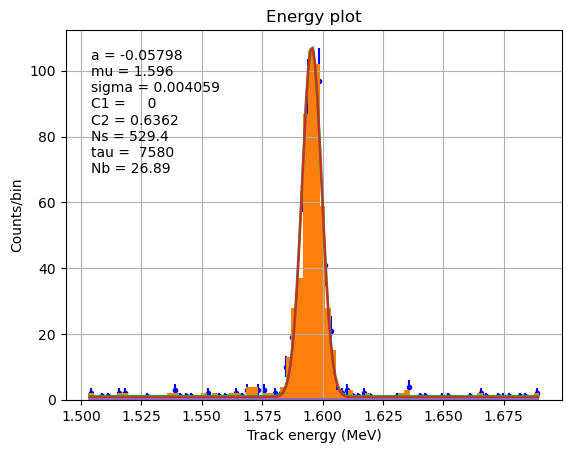

Signal events: 529.445925567149
Background events: 27.384225008146956
Total Events by addition: 556.8301505752959
Total Events by row counting: 551


Blob cut: 0.41000000000000003 MeV
Mu fit completed, with values:
mu: 1.5956895524419095
sigma: 0.004164036226463636


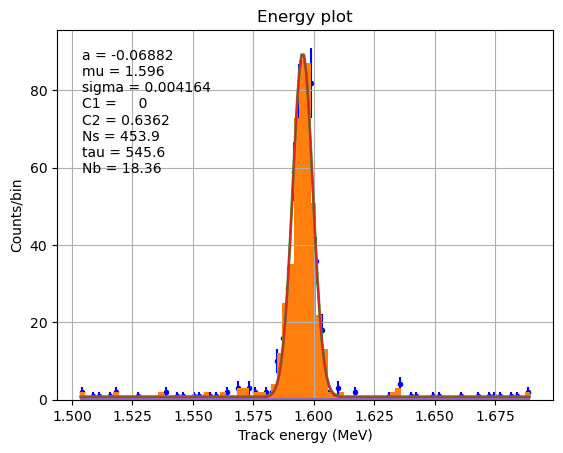

Signal events: 453.9270164467115
Background events: 18.767386121998296
Total Events by addition: 472.6944025687098
Total Events by row counting: 468


Blob cut: 0.42 MeV
Mu fit completed, with values:
mu: 1.5957285396164462
sigma: 0.004340332967665187


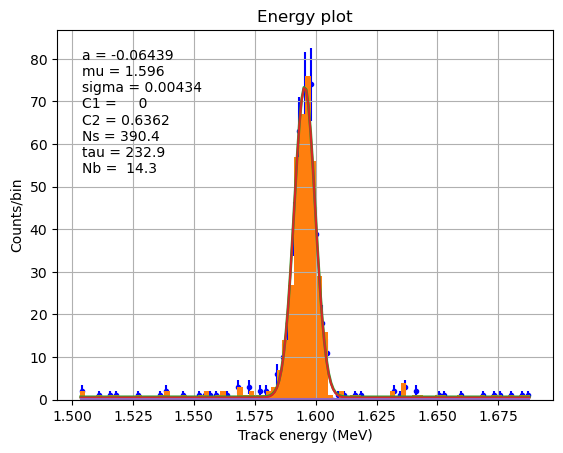

Signal events: 390.3678125911493
Background events: 13.955634221928925
Total Events by addition: 404.3234468130782
Total Events by row counting: 400


Blob cut: 0.43 MeV
Mu fit completed, with values:
mu: 1.5957072760535458
sigma: 0.004393507654936666


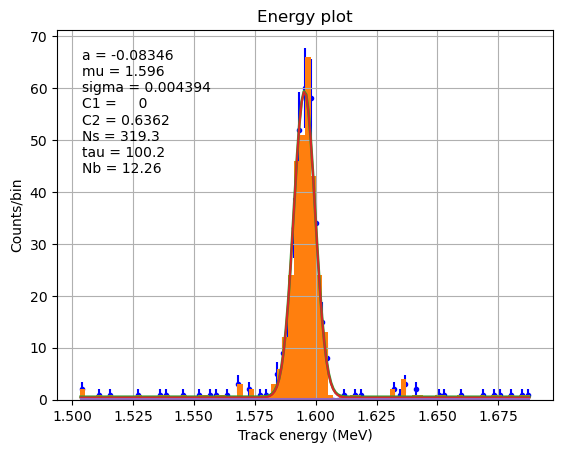

Signal events: 319.27230468048646
Background events: 12.543259370518546
Total Events by addition: 331.815564051005
Total Events by row counting: 328


Blob cut: 0.44 MeV
Mu fit completed, with values:
mu: 1.5958743580894403
sigma: 0.004646710579239454


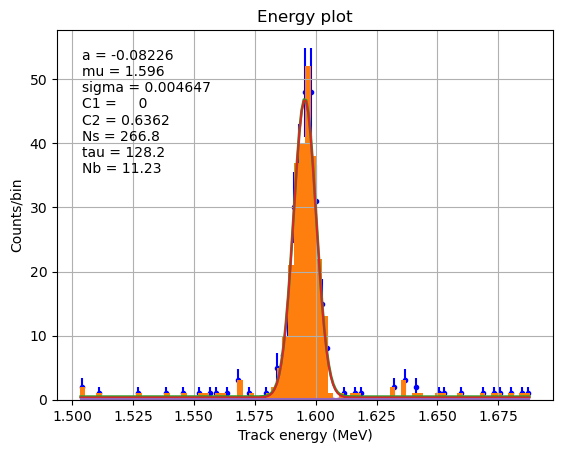

Signal events: 266.7927489598252
Background events: 11.469636416370072
Total Events by addition: 278.26238537619525
Total Events by row counting: 275


Blob cut: 0.45 MeV
Mu fit completed, with values:
mu: 1.5961339485625305
sigma: 0.004519905993961502


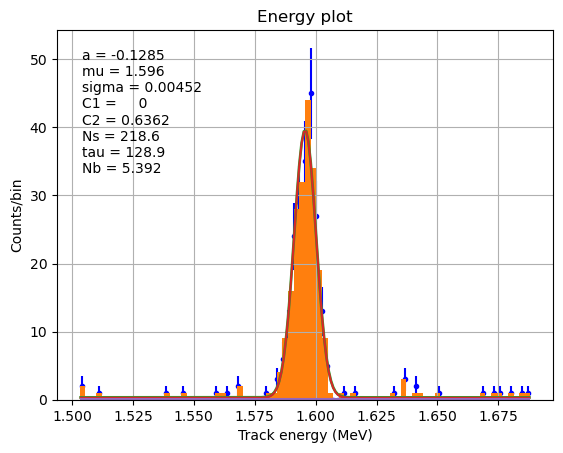

Signal events: 218.61913517054407
Background events: 5.5695641547887895
Total Events by addition: 224.18869932533286
Total Events by row counting: 222


Blob cut: 0.46 MeV
Mu fit completed, with values:
mu: 1.596109804134313
sigma: 0.004540314445596287


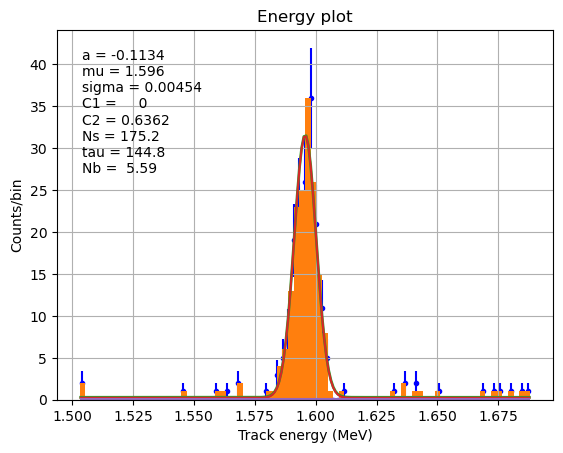

Signal events: 175.1767573243308
Background events: 5.734277341753999
Total Events by addition: 180.9110346660848
Total Events by row counting: 179


Blob cut: 0.47000000000000003 MeV
Mu fit completed, with values:
mu: 1.5959644256470336
sigma: 0.0043155411084685276


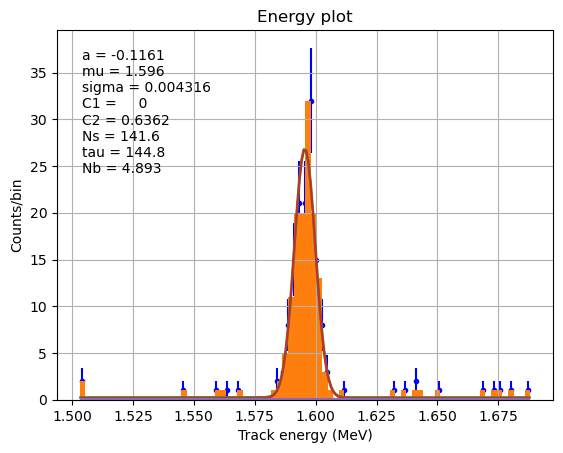

Signal events: 141.56208762162936
Background events: 5.008347430193762
Total Events by addition: 146.57043505182313
Total Events by row counting: 145


Blob cut: 0.48 MeV
Mu fit completed, with values:
mu: 1.5955623764178388
sigma: 0.003964152938338483


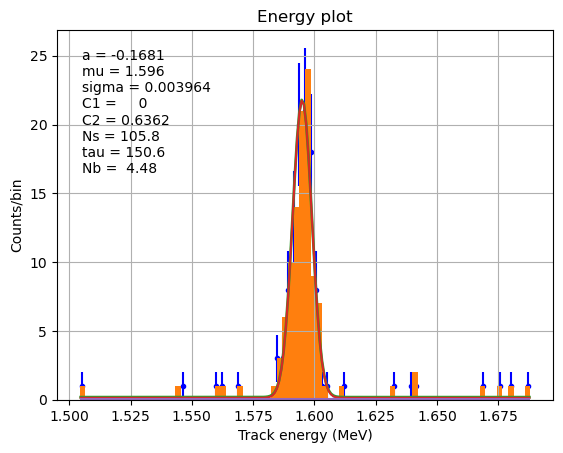

Signal events: 105.78001187897614
Background events: 4.569562770493138
Total Events by addition: 110.34957464946928
Total Events by row counting: 109


Blob cut: 0.49 MeV
Mu fit completed, with values:
mu: 1.5953421577734137
sigma: 0.004302281579377487


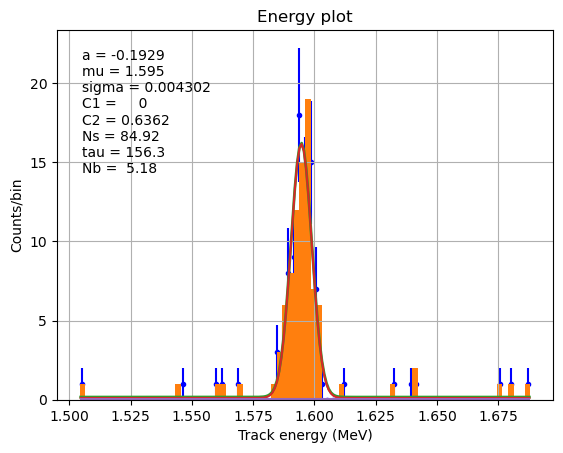

Signal events: 84.92328592035418
Background events: 5.253749159415611
Total Events by addition: 90.17703507976978
Total Events by row counting: 89


Blob cut: 0.5 MeV
Mu fit completed, with values:
mu: 1.5956494893249602
sigma: 0.003952233391268058


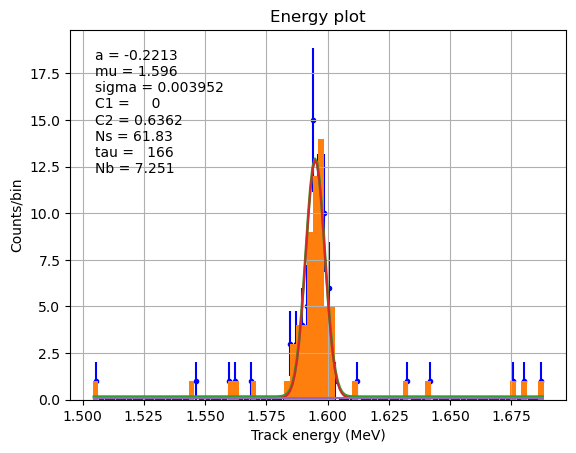

Signal events: 61.834236875818554
Background events: 7.313022366460562
Total Events by addition: 69.14725924227912
Total Events by row counting: 68


Blob cut: 0.51 MeV
Mu fit completed, with values:
mu: 1.5957432467689938
sigma: 0.004486079271113294


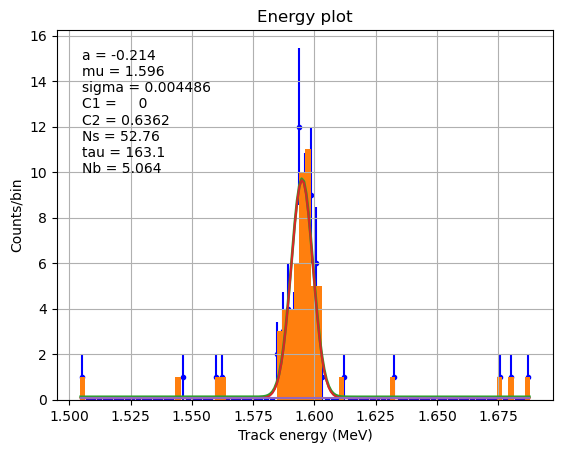

Signal events: 52.764811629706216
Background events: 5.112987159990766
Total Events by addition: 57.87779878969698
Total Events by row counting: 57


Blob cut: 0.52 MeV
Mu fit completed, with values:
mu: 1.595569573023646
sigma: 0.0034993993713779673


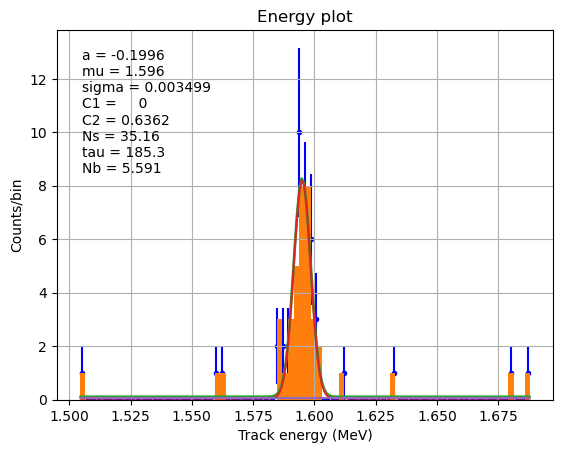

Signal events: 35.15808858734236
Background events: 5.629330572458773
Total Events by addition: 40.78741915980113
Total Events by row counting: 40


Blob cut: 0.53 MeV
Mu fit completed, with values:
mu: 1.5953187043808592
sigma: 0.002725264670229535


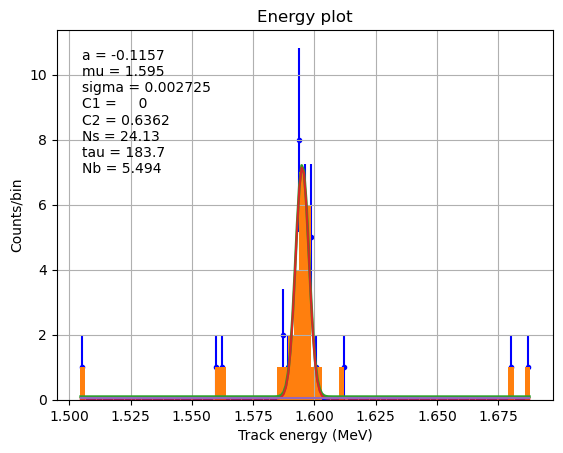

Signal events: 24.127115269337736
Background events: 5.522129145557328
Total Events by addition: 29.649244414895065
Total Events by row counting: 29


Blob cut: 0.54 MeV
Mu fit completed, with values:
mu: 1.5951663159841658
sigma: 0.0034795307832560804


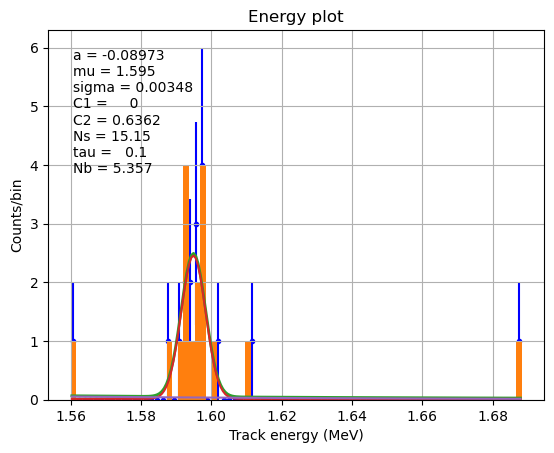

Signal events: 15.150449912662635
Background events: 5.327951061954654
Total Events by addition: 20.47840097461729
Total Events by row counting: 17


Blob cut: 0.55 MeV
Mu fit completed, with values:
mu: 1.5949755881844838
sigma: 0.0034542246520688565


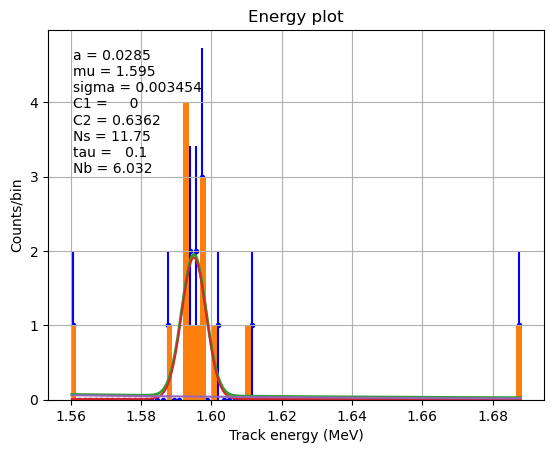

Signal events: 11.752836474095586
Background events: 6.0054245385678025
Total Events by addition: 17.75826101266339
Total Events by row counting: 14


Blob cut: 0.56 MeV
Mu fit completed, with values:
mu: 1.5928913047594755
sigma: 0.0003429661638182763


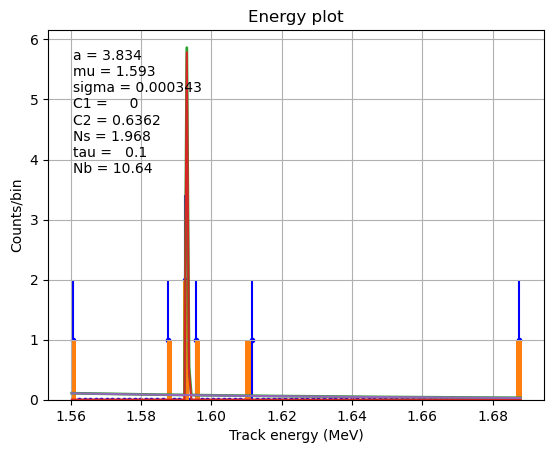

Signal events: 1.968472042176767
Background events: 10.625142060660334
Total Events by addition: 12.593614102837101
Total Events by row counting: 7


Blob cut: 0.5700000000000001 MeV
Mu fit completed, with values:
mu: 1.5932919492717805
sigma: 0.0002591104195679702


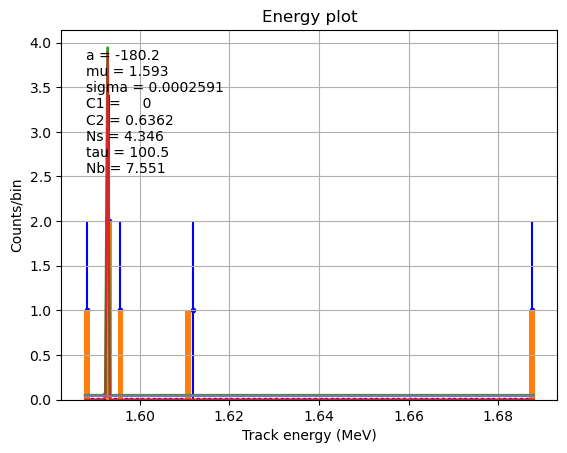

Signal events: 4.346198725120091
Background events: 7.536995295287903
Total Events by addition: 11.883194020407995
Total Events by row counting: 6


Blob cut: 0.58 MeV
Mu fit completed, with values:
mu: 1.5913194573662521
sigma: 0.0005973545059696011


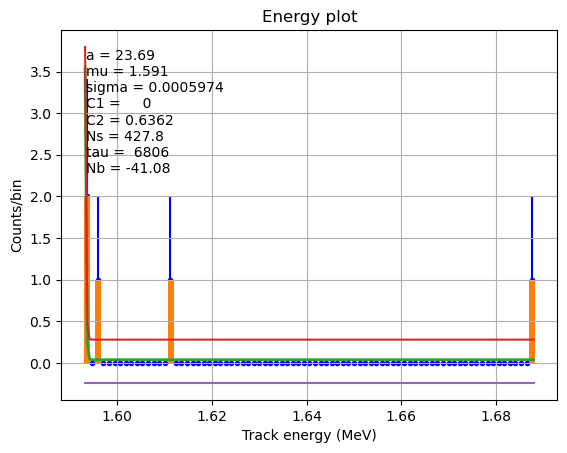

Signal events: 427.8235419897521
Background events: -41.09635830450275
Total Events by addition: 386.7271836852493
Total Events by row counting: 5


Blob cut: 0.59 MeV
Mu fit completed, with values:
mu: 1.5941497245982863
sigma: 0.0005899655205979791


/tmp/ipykernel_8618/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_8618/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


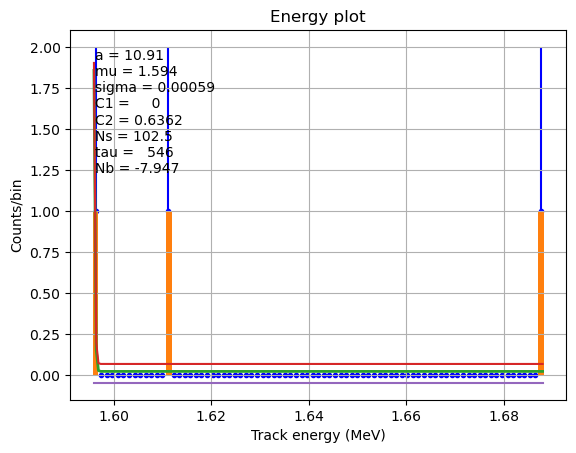

Signal events: 102.53900981323787
Background events: -7.939874276121416
Total Events by addition: 94.59913553711645
Total Events by row counting: 3


Blob cut: 0.6 MeV
Mu fit completed, with values:
mu: 1.6096137064080969
sigma: 0.0005077883288151736


/tmp/ipykernel_8618/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_8618/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


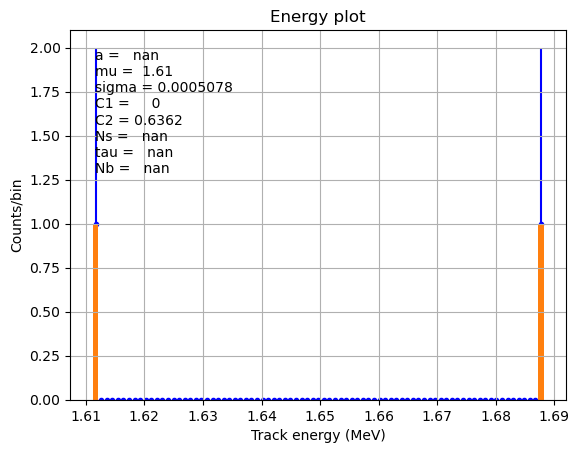

Signal events: -1236320001455.2593
Background events: -208712479582300.9
Total Events by addition: -209948799583756.16
Total Events by row counting: 2


/tmp/ipykernel_8618/4113164158.py:34: RuntimeWarning: invalid value encountered in sqrt
  fom_check = e_check/np.sqrt(b_check)
/tmp/ipykernel_8618/4113164158.py:41: RuntimeWarning: invalid value encountered in sqrt
  e_err.append(func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
/tmp/ipykernel_8618/4113164158.py:42: RuntimeWarning: invalid value encountered in sqrt
  b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
/home/e78368jw/Documents/NEXT_CODE/next_misc/core/functions.py:1314: RuntimeWarning: invalid value encountered in sqrt
  element_1 = np.square(a_error/np.sqrt(b))


In [25]:
for i in range(len(cut_list)):
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    print("")
    print("")
    print("====================================")
    print("Blob cut: {} MeV".format(cut_list[i]))
    print("====================================")
    # fit gaussian for mu and sigma    
    #holder = gaussian_fit(blob_data)
    #mu = holder[0]
    #sigma = holder[1]

    # apriori
    g_p0 = [500, 1.6, 0.01]
    g_labels = ['A', 'mu', 'sigma']
    binning = 80
    g_popt, g_pcov = func.histogram_fit(func.gauss, blob_data, binning, g_p0, g_labels)
    # set mu and sigma
    mu      = g_popt[1]
    sigma   = g_popt[2]

    print("Mu fit completed, with values:\nmu: {}\nsigma: {}".format(mu,sigma))
    holder_sb = sb_fit(blob_data, mu, sigma, C1, C2, plot = True)

    ns_l.append(holder_sb[0])
    nb_l.append(holder_sb[1])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(ns_l[i], nb_l[i],nb_l[i] + ns_l[i], len(blob_data.index)))
    
    # efficiency and background rej
    e_check = ns_l[i]/ns_l[0]
    b_check = nb_l[i]/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns_l[i],ns_l[0],np.sqrt(ns_l[i]),np.sqrt(ns_l[0])))
    b_err.append(func.ratio_error(b[i],nb_l[i],nb_l[0],np.sqrt(nb_l[i]),np.sqrt(nb_l[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data, mu, sigma, g_popt, g_pcov, holder_sb

    print("====================================")

In [17]:
print(fom)
plot = True

[]


VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   0 - FCN =   221466.6610722 Edm =       152867 NCalls =     11
VariableMetric: Iteration #   1 - FCN =  -45433.49578387 Edm =      3.24233 NCalls =     32
VariableMetric: Iteration #   2 - FCN =  -47387.59665699 Edm =      21.3433 NCalls =     47
VariableMetric: Iteration #   3 - FCN =  -47417.46503538 Edm =      1.57392 NCalls =     55
VariableMetric: Iteration #   4 - FCN =  -47421.37352002 Edm =     0.386177 NCalls =     63
VariableMetric: Iteration #   5 - FCN =  -47421.89157082 Edm =    0.0302811 NCalls =     71
VariableMetric: Iteration #   6 - FCN =  -47423.19952469 Edm =      1.11257 NCalls =     81
VariableMetric: Iteration #   7 - FCN =  -47787.71625605 Edm =      534.163 NCalls =     99
VariableMetric: Iteration #   8 - FCN =  -47788.87411038 Edm =     0.957382 NCalls =    107
VariableMetric: Iteration 

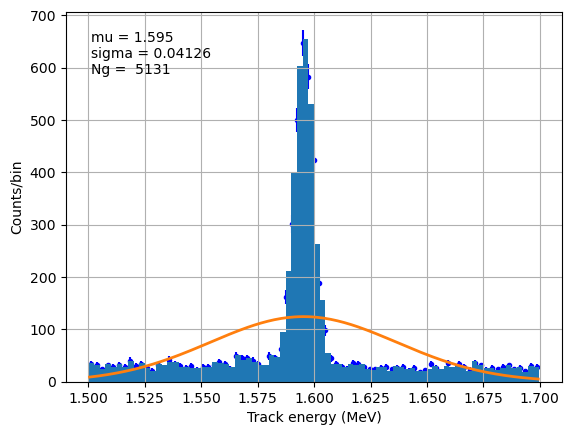

NameError: name 'pdf_sb' is not defined

In [18]:
'''
for i in range(len(cut_list)):
    try:
        del lh_sb, vals_sb, nm_sb, m_sb, m_g, lh_g,
    except:
        pass
    # generate data
    blob_data = cut_tracks[0][(cut_tracks[0]['eblob2'] > cut_list[i])]
    blob_np = blob_data['energy'].to_numpy()

    # produce gaussian fit
    lh_g = probfit.UnbinnedLH(gauss_norm_ext_, blob_np, extended = True)
    vals_g = [len(blob_np), 1.58, 0.004]
    nm_g = ['Ng', 'mu', 'sigma']

    m_g = Minuit(lh_g, **dict(zip(nm_g, vals_g)), 
                limit_mu=(fit_range[0], fit_range[1]), limit_Ng=(0,None), limit_sigma=(0,1),  print_level = 2)
    
    # minimise it
    m_g.migrad()

    print("Finished fitting gaussian")
    if (plot == True):
        # plot output
        heights, bins, _ = plt.hist(blob_np, binning)
        plt.xlabel("Track energy (MeV)")
        plt.ylabel("Counts/bin")
        lh_g.show(bins=binning+1, parts=True)
        plt.show()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_g.params[i][1],m_g.params[i][2]) for i in range(len(m_g.params))]
    mu = fit_params['mu']
    sigma = fit_params['sigma']

    # now do full fit
    try:
        del lh_sb, vals_sb, nm_sb, m_sb
    except:
        pass
    lh_sb = probfit.UnbinnedLH(pdf_sb, blob_np, extended = True)
    
    y, x = np.histogram(blob_np, fit_bins)
    x = shift_to_bin_centers(x)
    
    # give it rough starting spots
    vals_sb = [fit_params['Ng'], len(blob_np) - fit_params['Ng'], 0, mu, sigma, 100, C1, C2]
    nm_sb = ['Ns', 'Nb', 'a', 'mu', 'sigma', 'tau', 'C1', 'C2']

    m_sb = Minuit(lh_sb, **dict(zip(nm_sb, vals_sb)), fix_mu=True, fix_C1=True,
         fix_C2=True, fix_sigma=True, print_level = 2)

    # minimise that mfer
    m_sb.migrad()

    # pull out the relevant values
    fit_params = {}
    [add_element(fit_params, m_sb.params[i][1],m_sb.params[i][2]) for i in range(len(m_sb.params))]

    ns_l.append(fit_params['Ns'])
    nb_l.append(fit_params['Nb'])

    print("Signal events: {}\nBackground events: {}\nTotal Events by addition: {}\nTotal Events by row counting: {}".format(fit_params['Ns'], fit_params['Nb'],fit_params['Nb'] + fit_params['Ns'], len(blob_data[0].index)))

    # efficiency and background rej
    e_check = fit_params['Ns']/ns_l[0]
    b_check = fit_params['Nb']/nb_l[0]
    fom_check = e_check/np.sqrt(b_check)

    e.append(e_check)
    b.append(b_check)
    fom.append(fom_check)

        # errors for fom
    e_err.append(func.ratio_error(e[i],ns[i],ns[0],np.sqrt(ns[i]),np.sqrt(ns[0])))
    b_err.append(func.ratio_error(b[i],nb[i],nb[0],np.sqrt(nb[i]),np.sqrt(nb[0])))
    fom_err.append(func.fom_error(e[i], b[i], e_err[i], b_err[i]))

    del blob_data
'''

In [32]:
print(fom)

[1.0, 1.0, 1.007836330028552, 1.0317590124927782, 1.0808401164503738, 1.1653583364398958, 1.2531325230832562, 1.3727773682475406, 1.493158318656169, 1.6173290049355384, 1.7171192850537496, 1.8031043297857268, 1.913905778062748, 2.052415085569892, 2.180718679725098, 2.3224173732280837, 2.438920646258132, 2.5170015159840644, 2.4971164870730105, 2.513334106786307, 2.534078889494457, 2.5425547369933628, 2.559642420998936, 2.5397237096092167, 2.536261495774274, 2.52928113220616, 2.5216015116959887, 2.4835014688698727, 2.523864458149916, 2.5154137429534855, 2.3404496050665475, 2.498818676066676, 2.4538665414813066, 2.3976231723565915, 2.4127076808673857, 2.3479723883952492, 2.1448060155786575, 2.110438696872886, 2.034805604795255, 1.6550746662581464, 1.4649479679067323, 1.5171724691932411, 1.5130386728638618, 1.3052895537907754, 1.1406437176567694, 1.3413075928061933, 1.0592243412212872, 0.9159052552356141, 0.7165015004930185, 0.5364669104601687, 0.3310787989101313, 0.337876399439451, 0.2145

No handles with labels found to put in legend.


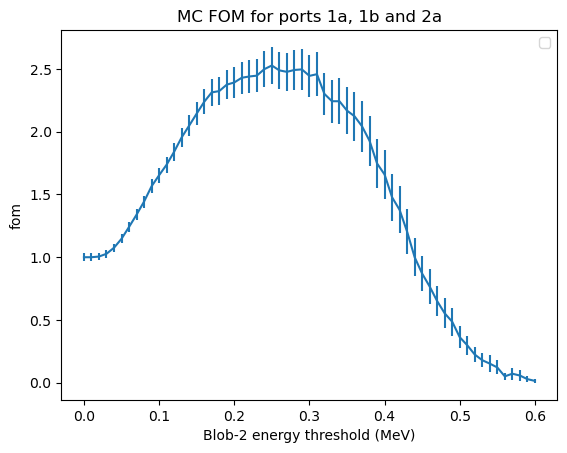

In [26]:
fom_MC = func.true_fom_calc(ecut_positron_df, ecut_no_positron_df, cut_list)

ns = fom_MC[2]
nb = fom_MC[3]
fom_erro = np.nan_to_num(fom_MC[1])
fom_out = np.nan_to_num(fom_MC[0])

plt.errorbar(cut_list, fom_out, yerr = fom_erro)
plt.title("MC FOM for ports 1a, 1b and 2a")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.legend()

plt.ylabel("fom")
plt.show()

/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/numpy/ma/core.py:3381: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/home/e78368jw/anaconda3/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


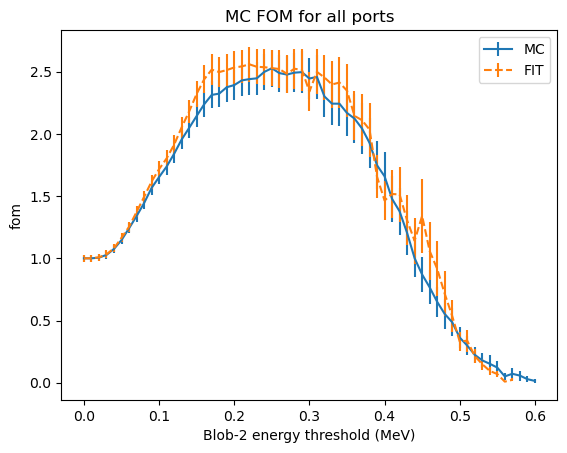

In [32]:
plt.errorbar(cut_list, fom_out, yerr = fom_erro, label = 'MC')
plt.errorbar(cut_list, fom, yerr = fom_err, label = 'FIT', linestyle = 'dashed')
plt.legend()
plt.title("MC FOM for all ports")
plt.xlabel("Blob-2 energy threshold (MeV)")
plt.ylabel("fom")
plt.show()

In [91]:
'''
e_s2 = np.append(e_s, e_s2)
#e_s = cut_tracks[0]['energy'].to_numpy()

# create unbinned likelihood object for fitting
lh_s = probfit.UnbinnedLH(sig_norm_ext, e_s2, extended = True)

# resolve bin edge problems
fit_bins = np.linspace(fit_range[0], fit_range[1], binning + 1)
y, x = np.histogram(e_s2, fit_bins)
x = shift_to_bin_centers(x)



# give it rough starting spots
vals = [len(e_s2), 0, 1.58, 0.3, 0, 0]
nm = ['Ns', 'a', 'mu', 'sigma', 'C1', 'C2']



params = dict(Ns = len(e_s2), a = 0, mu = 1.58, sigma=0.3, C1 = 0, C2 = 0)
m2 = Minuit(lh_s, **dict(zip(nm, vals)), limit_mu=(1.4,1.7), limit_C1=(0,None),
         limit_C2=(0,None), limit_sigma=(0,None), print_level = 2)
#m.limits['mu'] = (1.4, 1.7)
#m.limits['C1'] = (0, None)
#m.limits['C2'] = (0, None)
#m.limits['sigma'] = (0, None)
'''

In [35]:
np.save('data/fom_fit_isaura.npy', fom)
np.save('data/fom_fit_err_isaura.npy', fom_err)
np.save('data/fom_MC_isaura.npy', fom_out)
np.save('data/fom_MC_err_isaura.npy', fom_erro)

In [92]:
'''
# minimise that mfer
m2.migrad()
heights, bins, _ = plt.hist(e_s2, binning)
plt.xlabel("Track energy (MeV)")
plt.ylabel("Counts/bin")
lh_s.show(bins=binning+1, parts=True)
plt.show()
'''

VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   0 - FCN =  -99587.67616363 Edm =      4856.07 NCalls =     94
VariableMetric: Iteration #   1 - FCN =  -103883.8363617 Edm =      6118.56 NCalls =    119
VariableMetric: Iteration #   2 - FCN =  -108560.6179698 Edm =       914.85 NCalls =    143
VariableMetric: Iteration #   3 - FCN =  -108715.0329486 Edm =      451.082 NCalls =    159
VariableMetric: Iteration #   4 - FCN =  -108822.0763603 Edm =      29.2179 NCalls =    173
VariableMetric: Iteration #   5 - FCN =  -108830.6308968 Edm =      14.9261 NCalls =    187
VariableMetric: Iteration #   6 - FCN =  -108842.8533993 Edm =      4.13233 NCalls =    201
VariableMetric: Iteration #   7 - FCN =  -108850.6622825 Edm =      1.94108 NCalls =    215
VariableMetric: Iteration #   8 - FCN =  -108871.5466668 Edm =      10.4149 NCalls =    233
VariableMetric: Iteration 

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -1.089e+05                 │        Nfcn = 376 (376 total)        │
│ EDM = 2.87e-05 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │       SOME Parameters at limit       │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a     │   0.49    │   0.28    │            │            │         │         │       │
│ 1 │ mu    │  1.5939   │  0.0008   │            │            │   1.4   │   1.7   │       │
│ 2 │ sigma │  4.73e-3  │  0.31e-3  │            │            │    0    │         │       │
│ 3 │ C1    │   0.361   │   0.023   │            │            │    0    │         │       │
│ 4 │ C2    │   0.297   │   0.020   │            │            │    0    │         │       │
│ 5 │ Ns    │  9.39e3   │  0.10e3   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [36]:
test = np.load('data/fom_fit.npy')
print(test)

[1.         1.         1.00783633 1.03175901 1.08084012 1.16535834
 1.25313252 1.37277737 1.49315832 1.617329   1.71711929 1.80310433
 1.91390578 2.05241509 2.18071868 2.32241737 2.43892065 2.51700152
 2.49711649 2.51333411 2.53407889 2.54255474 2.55964242 2.53972371
 2.5362615  2.52928113 2.52160151 2.48350147 2.52386446 2.51541374
 2.34044961 2.49881868 2.45386654 2.39762317 2.41270768 2.34797239
 2.14480602 2.1104387  2.0348056  1.65507467 1.46494797 1.51717247
 1.51303867 1.30528955 1.14064372 1.34130759 1.05922434 0.91590526
 0.7165015  0.53646691 0.3310788  0.3378764  0.21455947 0.14866301
 0.09503777 0.06944191 0.00874405 0.02292246        nan        nan
        nan]
